# Kaggle: Plant Pathology 2021 - FGVC8

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Borda/kaggle_image-classify/blob/main/notebooks/Plant-Pathology-with-Lightning.ipynb)

In [1]:
! pip install -q -U timm "pytorch-lightning==1.5.*"
# ! pip install -q https://github.com/Borda/kaggle_image-classify/archive/main.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch
! pip list | grep kaggle

efficientnet-pytorch              0.6.3
pytorch-lightning                 1.5.10
segmentation-models-pytorch       0.2.1
torch                             1.10.2
torchaudio                        0.10.2
torchmetrics                      0.7.2
torchvision                       0.11.3
torchviz                          0.0.2
kaggle-plant-pathology            0.5.0


In [2]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3ed86717-e5ae-87cb-9d97-ef78e51514e0)


## Data exploration

Checking what data do we have available and what is the labels distribution...

In [3]:
# ! apt-get install -qq -y imagemagick
# ! mogrify -resize 960 train_images/*.jpg

Looking in the training dataset table, what colums and what is the data representation...

In [4]:
%matplotlib inline

import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

base_path = "/home/jovyan/datastores/kaggle_image-classify"
path_csv = os.path.join(base_path, "train.csv")
train_data = pd.read_csv(path_csv)
display(train_data.head())

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


We can see that each image can have multiple labels so lets check what is the mos common label count...

*The target classes, a space delimited list of all diseases found in the image.
Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.*

In [5]:
train_data["nb_classes"] = [len(lbs.split(" ")) for lbs in train_data["labels"]]
lb_hist = dict(zip(range(10), np.bincount(train_data["nb_classes"])))
pprint(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


Browse the label distribution, enrolling all labels in the dataset, so in case an image has two labels both are used in this stat...

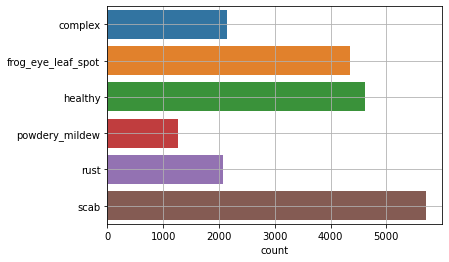

In [6]:
import itertools

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in train_data["labels"]]))

ax = sns.countplot(y=sorted(labels_all), orient="v")
ax.grid()

Get some stat for labels combinations...

In [7]:
labels_unique = set(labels_all)
print(f"unique labels: {labels_unique}")
train_data["labels_sorted"] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data["labels"]]

labels_combine = {}
for comb in train_data["labels_sorted"]:
    labels_combine[comb] = labels_combine.get(comb, 0) + 1

show_counts = "\n".join(sorted(f"\t{k}: {v}" for k, v in labels_combine.items()))
print("unique combinations: \n" + show_counts)
print(f"total: {sum(labels_combine.values())}")

unique labels: {'frog_eye_leaf_spot', 'rust', 'powdery_mildew', 'complex', 'scab', 'healthy'}
unique combinations: 
	complex frog_eye_leaf_spot scab: 200
	complex frog_eye_leaf_spot: 165
	complex powdery_mildew: 87
	complex rust: 97
	complex: 1602
	frog_eye_leaf_spot rust: 120
	frog_eye_leaf_spot scab: 686
	frog_eye_leaf_spot: 3181
	healthy: 4624
	powdery_mildew: 1184
	rust: 1860
	scab: 4826
total: 18632


And add visualisation over each case, so five a few examples per labe combination...

(-0.5, 639.5, 427.5, -0.5)

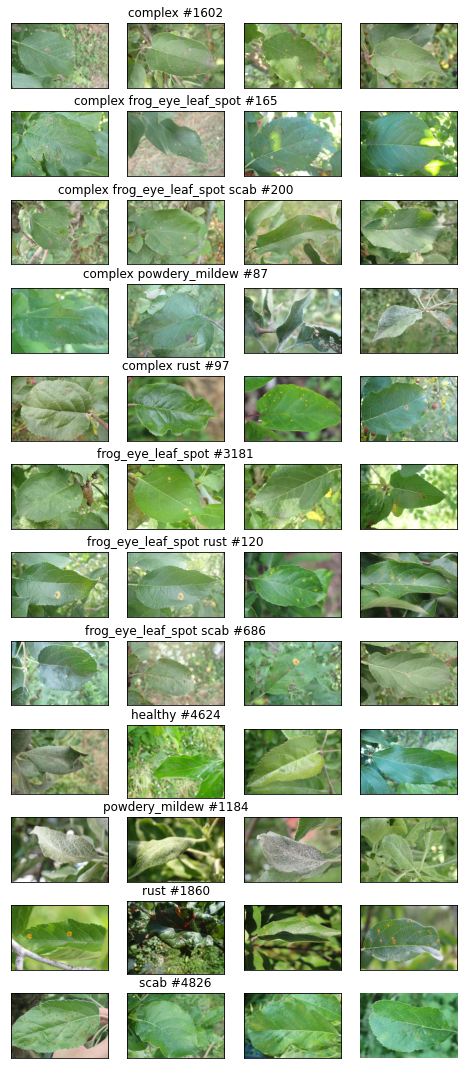

In [8]:
nb_samples = 4
n, m = len(np.unique(train_data["labels_sorted"])), nb_samples
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 1.6))
for ilb, (lb, df_) in enumerate(train_data.groupby("labels_sorted")):
    img_names = list(df_["image"])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 1:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis("off")

## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations.
We define the sample pair as:
 - RGB image
 - one-hot labels encoding

A DataModule standardizes the training, val, test splits, data preparation and transforms.
The main advantage is consistent data splits, data preparation and transforms across models.

In [9]:
import glob
import itertools
import logging
from typing import Dict, List, Optional, Sequence, Tuple, Type, Union
from warnings import warn

from PIL import Image
from pytorch_lightning import LightningDataModule
from torch import Tensor
from torch.utils.data import DataLoader, Dataset


class PlantPathologyDataset(Dataset):
    """The ful dataset with one-hot encoding for multi-label case."""

    def __init__(
        self,
        df_data: Union[str, pd.DataFrame] = "train.csv",
        path_img_dir: str = "train_images",
        transforms=None,
        mode: str = "train",
        split: float = 0.8,
        uq_labels: Tuple[str] = None,
        random_state=42,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        # set or load the config table
        if isinstance(df_data, pd.DataFrame):
            self.data = df_data
        elif isinstance(df_data, str):
            assert os.path.isfile(df_data), f"missing file: {df_data}"
            self.data = pd.read_csv(df_data)
        else:
            raise ValueError(f"unrecognised input for DataFrame/CSV: {df_data}")

        # take over existing table or load from file
        if uq_labels:
            self.labels_unique = tuple(uq_labels)
        else:
            labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in self.raw_labels]))
            self.labels_unique = tuple(sorted(set(labels_all)))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # shuffle data
        self.data = self.data.sample(frac=1, random_state=random_state).reset_index(drop=True)

        # split dataset
        assert 0.0 <= split <= 1.0, f"split {split} is out of range"
        frac = int(split * len(self.data))
        self.data = self.data[:frac] if mode == "train" else self.data[frac:]
        self.img_names = list(self.data["image"])
        self.labels = self._prepare_labels()
        # compute importance order
        self.label_importance_index = []

    @property
    def raw_labels(self):
        return list(self.data["labels"])

    def _prepare_labels(self) -> list:
        return [torch.tensor(self.to_binary_encoding(lb)) if lb else None for lb in self.raw_labels]

    def to_binary_encoding(self, labels: str) -> tuple:
        # processed with encoding
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_name = self.img_names[idx]
        img_path = os.path.join(self.path_img_dir, img_name)
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        # in case of predictions, return image name as label
        label = label if label is not None else img_name
        return img, label

    def __len__(self) -> int:
        return len(self.data)

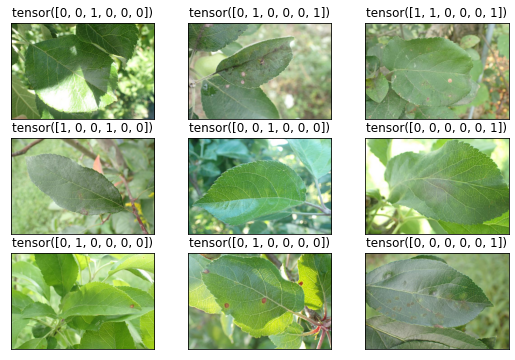

In [10]:
import os

import torch

dataset = PlantPathologyDataset(df_data=path_csv, path_img_dir=os.path.join(base_path, "train_images"))

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

In [11]:
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


class PlantPathologyDM(LightningDataModule):
    labels_unique: Sequence
    lut_label: Dict

    def __init__(
        self,
        path_csv: str = "train.csv",
        base_path: str = ".",
        batch_size: int = 24,
        num_workers: int = None,
        simple: bool = False,
        train_transforms=None,
        valid_transforms=None,
        split: float = 0.8,
    ):
        super().__init__()
        # path configurations
        assert os.path.isdir(base_path), f"missing folder: {base_path}"
        self.train_dir = os.path.join(base_path, "train_images")
        self.test_dir = os.path.join(base_path, "test_images")

        if not os.path.isfile(path_csv):
            path_csv = os.path.join(base_path, path_csv)
        assert os.path.isfile(path_csv), f"missing table: {path_csv}"
        self.path_csv = path_csv

        # other configs
        self.batch_size = batch_size
        self.split = split
        self.num_workers = num_workers if num_workers is not None else os.cpu_count()

        # need to be filled in setup()
        self.train_dataset = None
        self.valid_dataset = None
        self.test_table = []
        self.test_dataset = None
        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return max(self.train_dataset.num_classes, self.valid_dataset.num_classes)

    def setup(self, *_, **__) -> None:
        """Prepare datasets"""
        assert os.path.isdir(self.train_dir), f"missing folder: {self.train_dir}"
        ds = PlantPathologyDataset(self.path_csv, self.train_dir, mode="train", split=1.0)
        self.labels_unique = ds.labels_unique
        self.lut_label = dict(enumerate(self.labels_unique))

        ds_defaults = dict(
            df_data=self.path_csv,
            path_img_dir=self.train_dir,
            split=self.split,
            uq_labels=self.labels_unique,
        )
        self.train_dataset = PlantPathologyDataset(**ds_defaults, mode="train", transforms=self.train_transforms)
        logging.info(f"training dataset: {len(self.train_dataset)}")
        self.valid_dataset = PlantPathologyDataset(**ds_defaults, mode="valid", transforms=self.valid_transforms)
        logging.info(f"validation dataset: {len(self.valid_dataset)}")

        if not os.path.isdir(self.test_dir):
            return
        ls_images = glob.glob(os.path.join(self.test_dir, "*.*"))
        ls_images = [os.path.basename(p) for p in ls_images if os.path.splitext(p)[-1] in IMAGE_EXTENSIONS]
        self.test_table = [dict(image=n, labels="") for n in ls_images]
        self.test_dataset = PlantPathologyDataset(
            df_data=pd.DataFrame(self.test_table),
            path_img_dir=self.test_dir,
            split=0,
            uq_labels=self.labels_unique,
            mode="test",
            transforms=self.valid_transforms,
        )
        logging.info(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self) -> Optional[DataLoader]:
        if self.test_dataset:
            return DataLoader(
                self.test_dataset,
                batch_size=self.batch_size,
                num_workers=0,
                shuffle=False,
            )
        logging.warning("no testing images found")

In [12]:
from torchvision import transforms as T

#: default training augmentation
TORCHVISION_TRAIN_TRANSFORM = T.Compose([
    T.Resize(size=512, interpolation=Image.BILINEAR),
    T.RandomRotation(degrees=30),
    T.RandomPerspective(distortion_scale=0.4),
    T.RandomResizedCrop(size=300),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
#: default validation augmentation
TORCHVISION_VALID_TRANSFORM = T.Compose([
    T.Resize(size=512, interpolation=Image.BILINEAR),
    T.CenterCrop(size=300),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

/home/jovyan/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


The DataModule include creating training and validation dataset with given split and feading it to particular data loaders...

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:121: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:114: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


classes: 6


batch labels: tensor([1, 2, 3, 2, 1, 5])
image size: torch.Size([3, 300, 300])


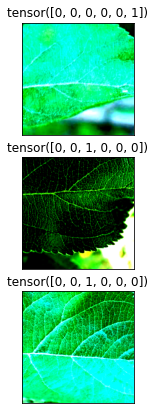

In [13]:
dm = PlantPathologyDM(
    path_csv=path_csv,
    base_path=base_path,
    simple=False,
    batch_size=12,
    train_transforms=TORCHVISION_TRAIN_TRANSFORM,
    valid_transforms=TORCHVISION_VALID_TRANSFORM,
    split=0.9,
    num_workers=6,
)
dm.setup()
print(f"classes: {dm.num_classes}")

# Quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.val_dataloader():
    print(f"batch labels: {torch.sum(lbs, axis=0)}")
    print(f"image size: {imgs[0].shape}")
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some stanrd CNN models taken from torch vision.
Then we define Ligthning module including training and validation step and configure optimizer/schedular.

See: https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055

In [14]:
from typing import Optional, Union

import timm
from pytorch_lightning import LightningModule
from torch import nn
from torch.nn import functional as F
from torchmetrics import F1Score


class MultiPlantPathology(LightningModule):
    def __init__(
        self,
        model: Union[nn.Module, str] = "resnet50",
        num_classes: int = 6,
        lr: float = 1e-4,
    ):
        super().__init__()
        if isinstance(model, str):
            self.arch = model
            self.model = timm.create_model(model, pretrained=True, num_classes=num_classes)
        else:
            self.model = model
            self.arch = model.__class__.__name__
        self.train_f1_score = F1Score(num_classes=num_classes, average="weighted")
        self.val_f1_score = F1Score(num_classes=num_classes, average="weighted")
        self.learning_rate = lr

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(self.model(x))

    def compute_loss(self, y_hat: Tensor, y: Tensor):
        return F.binary_cross_entropy_with_logits(y_hat, y.to(y_hat.dtype))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_f1", self.train_f1_score(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=True)
        self.log("valid_f1", self.val_f1_score(y_hat, y), prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

In [15]:
model = MultiPlantPathology(model="tf_efficientnet_b3_ns", lr=5e-4)

## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [16]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger(save_dir="logs/", name=model.arch)
# swa = StochasticWeightAveraging(swa_epoch_start=0.6)
ckpt = ModelCheckpoint(
    monitor="valid_f1",
    save_top_k=1,
    save_last=True,
    # save_weights_only=True,
    filename="checkpoint/{epoch:02d}-{valid_f1:.4f}",
    # verbose=False,
    mode="max",
)

# ==============================

trainer = Trainer(
    # fast_dev_run=True,
    gpus=1,
    callbacks=[ckpt],
    logger=logger,
    max_epochs=10,
    precision=16,
    # overfit_batches=5,
    accumulate_grad_batches=20,
    val_check_interval=0.5,
    # progress_bar_refresh_rate=1,
    weights_summary="top",
)

# ==============================

# lr_find_kwargs = dict(min_lr=1e-5, max_lr=1e-2, num_training=25)
# trainer.tune(model, datamodule=dm, lr_find_kwargs=lr_find_kwargs)
# print(f"LR: {model.learning_rate}")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model=model, datamodule=dm)

Quick visualization of the training process...

,valid_loss,valid_f1,train_loss,train_f1
epoch,,,,
0,0.669231,0.444593,NaN,NaN
0,NaN,NaN,0.659689,0.620370
0,0.654051,0.743124,NaN,NaN
1,NaN,NaN,0.667019,0.582418
1,0.651335,0.759330,NaN,NaN


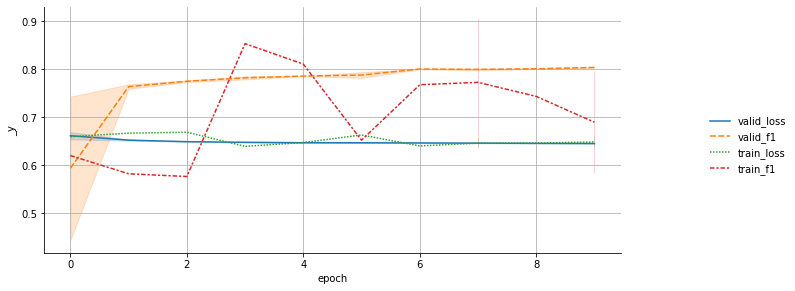

In [18]:
import matplotlib.pyplot as plt
import seaborn as sn

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
plt.grid()

## Predictions on tests data

Run simple predictions on testing data and form in expected output

image size: torch.Size([3, 300, 300])


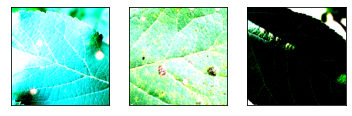

In [19]:
fig = plt.figure(figsize=(6, 2))
for imgs, lbs in dm.test_dataloader():
    print(f"image size: {imgs[0].shape}")
    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3) + 0.5)
    break

In [20]:
dm.batch_size = 8
model.cpu().eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        encode = model(imgs)
    print(np.round(encode.detach().numpy(), decimals=2))
    break

[[0.   1.   0.   0.   0.   0.01]
 [0.   1.   0.   0.   0.   0.13]
 [0.   0.   0.   0.   0.   1.  ]]


## Replicate

dump the trained model and try to load it again to see if it gives the same results...

### Save with Pytorch-Lignnting ckpt

In [21]:
# ! ls -l logs/resnet50/version_*/checkpoints/checkpoint
print(ckpt.best_model_path)
# print(vars(ckpt))

logs/tf_efficientnet_b3_ns/version_2/checkpoints/checkpoint/epoch=09-valid_f1=0.8048.ckpt


In [23]:
model3 = MultiPlantPathology(model="tf_efficientnet_b3_ns")
weight = torch.load(ckpt.last_model_path, map_location=torch.device("cpu"))
model3.load_state_dict(weight["state_dict"])
# model2 = MultiPlantPathology.load_from_checkpoint(ckpt.best_model_path)

<All keys matched successfully>

In [24]:
preds = []
model3.eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        encode = model3(imgs)
    print(np.round(encode.detach().numpy(), decimals=2))
    break

[[0.   1.   0.   0.   0.   0.01]
 [0.   1.   0.   0.   0.   0.13]
 [0.   0.   0.   0.   0.   1.  ]]
